In [1]:
import sys
sys.path.append("../src")

import os

import cv2
import torch
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision.datasets import CIFAR10, CIFAR100

from utils import (
    get_encoder_args,
    Encoder,
    RGB
    )

/Users/ericmonzon/mambaforge/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
backbone = "vit-s-16"
experiment_num = 1

ckpt_dir = os.path.join("..", "assets", "model-weights", backbone, "pre-train", f"version_{experiment_num}", "min-loss.ckpt")
run_dir = os.path.join("..", "src", "pre-train-runs", backbone, f"version_{experiment_num}", "run-config.yaml")

ckpt = torch.load(ckpt_dir, map_location=torch.device("cpu"))["state_dict"]

In [3]:
encoder_args = get_encoder_args(run_dir)

encoder = Encoder(**encoder_args)

encoder

Encoder(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
  

In [4]:
student_params = {k: params for k, params in ckpt.items() if "student." in k}
student_params = {k.replace("student.", ""): params for k, params in student_params.items()}

encoder.load_state_dict(student_params)

<All keys matched successfully>

In [5]:
encoder = encoder.encoder

encoder

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [6]:
encoder.blocks[-1].attn.head_dim

64

In [7]:
transform = transforms.Compose([
            RGB(),
            transforms.RandomResizedCrop(512, scale=(0.75, 0.85)),
            transforms.ToTensor()
        ])

normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

def transform_fn(batch):
    batch["image"] = [transform(img) for img in batch["image"]]

    return batch


In [8]:
data_dir = os.path.join("..", "data")

dataset = load_dataset("ILSVRC/imagenet-1k", cache_dir=data_dir, split="validation")
dataset.set_transform(transform_fn)

loader = DataLoader(dataset, batch_size=10, shuffle=True)

batch = next(iter(loader))

In [9]:
batch["image"].shape

torch.Size([10, 3, 512, 512])

In [10]:
idx = 0

raw_img = batch["image"][idx]
target = batch["label"][idx]

img = normalize(raw_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


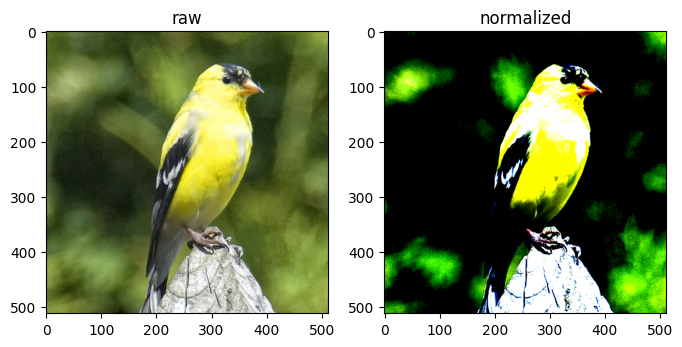

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(raw_img.permute(1, 2, 0).numpy())
axes[0].set_title("raw")

axes[1].imshow(img.permute(1, 2, 0).numpy())
axes[1].set_title("normalized")

plt.show()

In [12]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 512, 512])

In [13]:
num_heads = encoder.blocks[-1].attn.num_heads

num_heads

6

In [14]:
attention_maps = []

def extract_attn(module, inpt, outpt):
    B, N ,C = inpt[0].shape
    qkv = module.qkv(inpt[0]).reshape(B, N, 3, module.num_heads, module.head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv.unbind(0)
    
    attn_weights = (q @ k.transpose(-2, -1)) * module.scale
    attn_weights = attn_weights.softmax(dim=-1)
    attention_maps.append(attn_weights)

for block in encoder.blocks:
    block.attn.register_forward_hook(extract_attn)

encoder.eval()
with torch.inference_mode():
    _ = encoder(img)

In [15]:
attention_maps[-1][:, 0, :].shape

torch.Size([1, 1025, 1025])

In [16]:
attention_maps[-1][:, :, 0, 1:].shape

torch.Size([1, 6, 1024])

In [17]:
cls_attention = attention_maps[-1][:, :, 0, 1:]

dim_patches = int(cls_attention.shape[-1] ** 0.5)
head0 = cls_attention[:, 0, :].reshape(-1, dim_patches, dim_patches)

attention_map = F.interpolate(
    head0.unsqueeze(0),
    size=(img.shape[2], img.shape[3])
)

In [18]:
head0.shape

torch.Size([1, 32, 32])

In [19]:
attention_map_per_head = []

for i in range(3):
    head_attention = cls_attention[:, i, :].reshape(-1, dim_patches, dim_patches)
    attention_map = F.interpolate(
        head_attention.unsqueeze(0),
        size=(img.shape[-2], img.shape[-1])
    ).squeeze().numpy()

    attention_map_per_head.append(attention_map)


avg_attention = cls_attention.mean(dim=1).reshape(-1, dim_patches, dim_patches)
avg_attention_map = F.interpolate(
        avg_attention.unsqueeze(0),
        size=(img.shape[-2], img.shape[-1])
    ).squeeze().numpy()

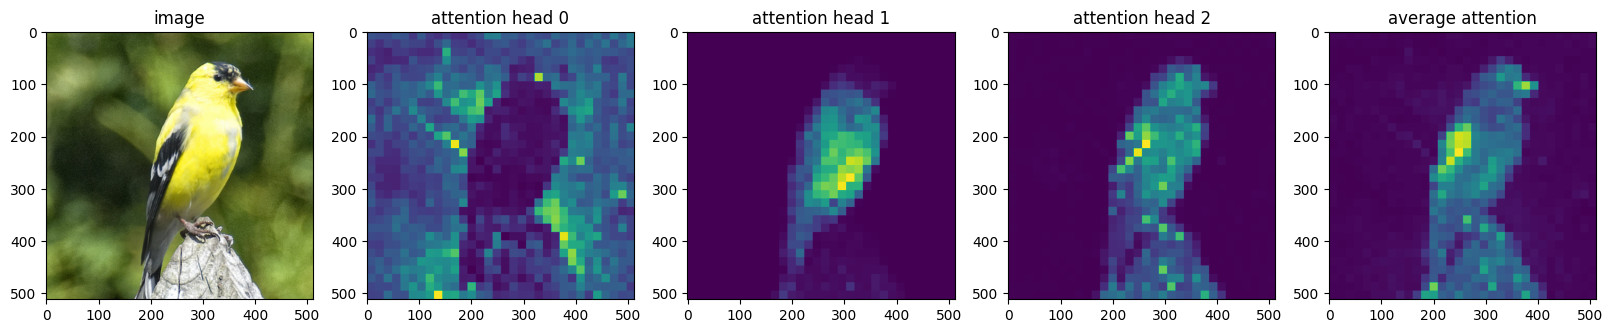

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

axes[0].imshow(raw_img.permute(1, 2, 0).numpy())
axes[0].set_title("image")

for i in range(3):
    axes[i+1].imshow(attention_map_per_head[i], cmap="viridis")
    axes[i+1].set_title(f"attention head {i}")


axes[-1].imshow(avg_attention_map, cmap="viridis")
axes[-1].set_title("average attention")

plt.show()